<a href="https://colab.research.google.com/github/NivedhaBalakrishnan/Starbucks-Time-Series-Forecasting/blob/main/Starbucks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.layers import Dense,Dropout,GRU
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping, LearningRateScheduler


# Import Starbucks stock prices from Yahoo! Finance
data = yf.download('SBUX')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-06-26,0.328125,0.347656,0.320313,0.335938,0.265714,224358400
1992-06-29,0.339844,0.367188,0.332031,0.359375,0.284252,58732800
1992-06-30,0.367188,0.371094,0.343750,0.347656,0.274982,34777600
1992-07-01,0.351563,0.359375,0.339844,0.355469,0.281162,18316800
1992-07-02,0.359375,0.359375,0.347656,0.355469,0.281162,13996800
...,...,...,...,...,...,...
2023-10-03,90.500000,91.070000,89.209999,89.480003,89.480003,6666600
2023-10-04,89.889999,91.430000,89.809998,91.150002,91.150002,6166100
2023-10-05,91.139999,93.050003,91.139999,92.370003,92.370003,7548600


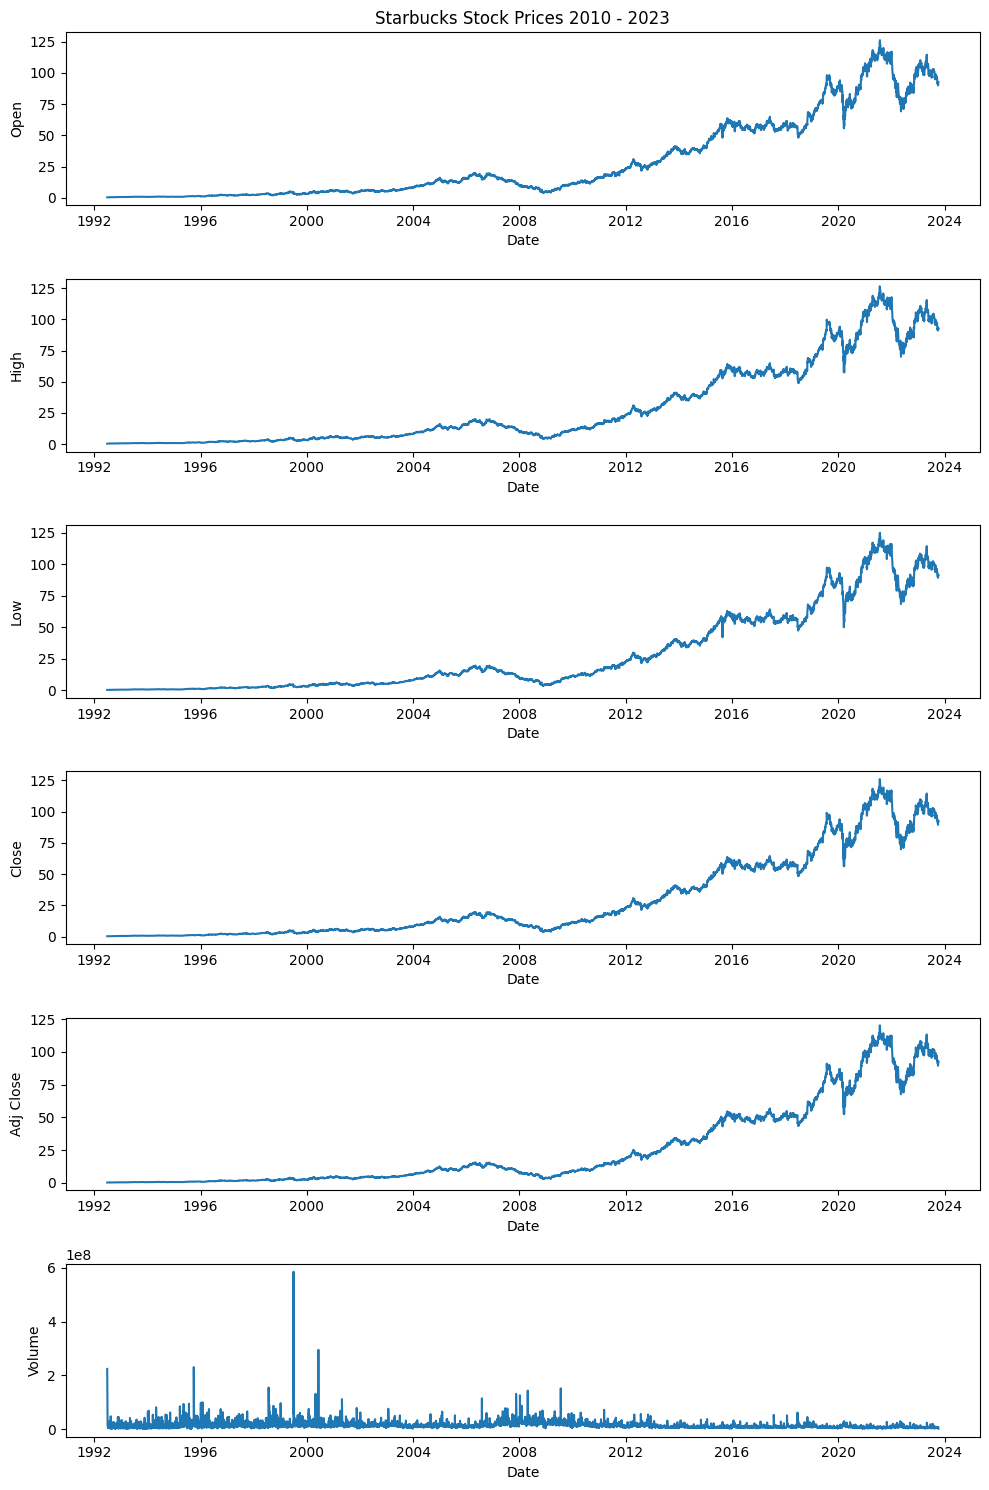

In [9]:
def plot_col(df):
  num_cols = len(df.columns)
  fig, ax = plt.subplots(num_cols, figsize=(10, 2.5*num_cols))
  for i, column in enumerate(df.columns):
    sns.lineplot(ax=ax[i], data=df, x=df.index, y=column)
    ax[0].set_title('Starbucks Stock Prices 2010 - 2023')
  plt.tight_layout()
  plt.show()

plot_col(data)


Text(0.5, 1.0, 'Starbucks Closed Finance Time Series')

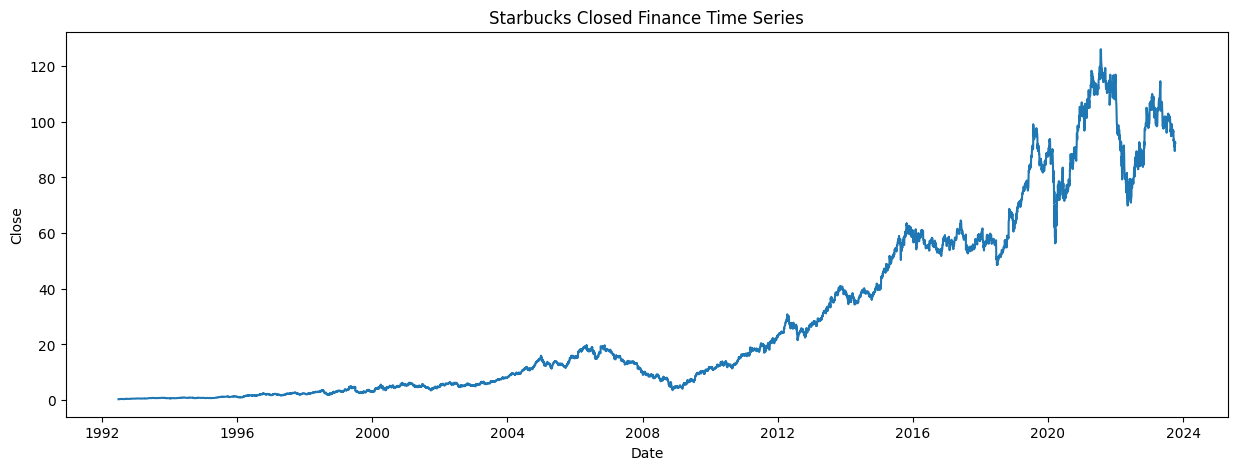

In [10]:

plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
plt.title('Starbucks Closed Finance Time Series')

In [11]:
split_time = '2020-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [12]:
train_close_data = train_data['Close']
valid_close_data = test_data['Close']

print(f'Train Closed Data \n{train_close_data.head()}\n')
print(f'Validation Closed Data \n{valid_close_data.head()}\n')

Train Closed Data 
Date
1992-06-26    0.335938
1992-06-29    0.359375
1992-06-30    0.347656
1992-07-01    0.355469
1992-07-02    0.355469
Name: Close, dtype: float64

Validation Closed Data 
Date
2020-01-02    89.349998
2020-01-03    88.830002
2020-01-06    88.129997
2020-01-07    87.860001
2020-01-08    88.879997
Name: Close, dtype: float64



### Forecasting with Machine Learning

In [13]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size=30
train_set = window_dataset(train_close_data, window_size)
valid_set = window_dataset(valid_close_data, window_size)

#Model building
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer= keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

#Model Compiling
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [16]:

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch /30)
)

history = model.fit(train_set, epochs=200,
                    validation_data=valid_set,
                    callbacks=[early_stopping,lr_schedule], verbose=-1)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200


45


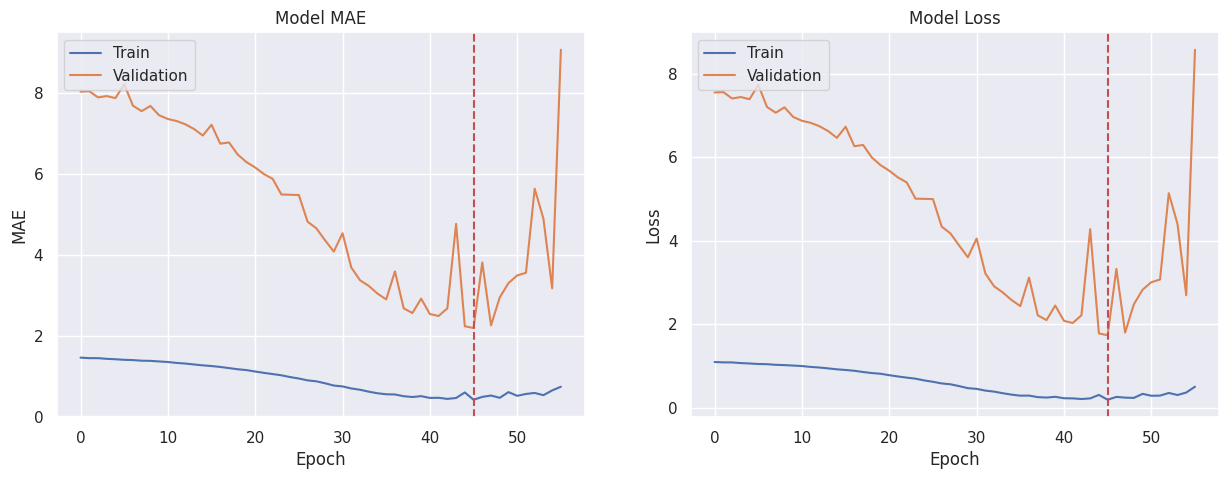

In [18]:
def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='r', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='r', linestyle='--')

  plt.show()


plot_history(history)

The best epoch is 48 it is Auto Restored by Early Stopping Callback

In [19]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [20]:
#Forecasting
forecast = model_forecast(model, valid_close_data, window_size)[:, 0]
forecast

29/29 [==============================] - 0s 7ms/step


array([ 86.68319 ,  86.46029 ,  88.944336,  89.5936  ,  88.90787 ,
        90.027374,  90.324524,  87.95001 ,  85.85811 ,  84.06894 ,
        82.310814,  80.601364,  77.19269 ,  77.04295 ,  75.49672 ,
        75.52252 ,  72.78463 ,  75.5161  ,  70.29289 ,  65.68599 ,
        69.37778 ,  62.640427,  64.367935,  57.5744  ,  64.11391 ,
        60.05427 ,  58.669693,  59.48239 ,  58.82592 ,  63.782578,
        57.903965,  62.191116,  63.883625,  70.025116,  70.32172 ,
        69.692375,  68.034424,  72.966   ,  72.29163 ,  69.864296,
        69.77089 ,  77.06747 ,  72.51734 ,  70.54361 ,  79.4001  ,
        72.1806  ,  72.56855 ,  69.66423 ,  75.22752 ,  79.11621 ,
        78.39666 ,  81.36567 ,  77.73987 ,  78.796906,  72.9183  ,
        72.405334,  72.774055,  72.51997 ,  76.233376,  73.35949 ,
        75.73923 ,  71.536545,  72.15587 ,  73.87468 ,  75.36602 ,
        78.518524,  73.52321 ,  74.41655 ,  76.27956 ,  75.150345,
        75.08408 ,  80.1367  ,  79.996925,  81.44689 ,  80.492

In [21]:
forecast_df = pd.DataFrame(forecast[:-1],
                           index=valid_close_data.index[window_size:window_size+len(forecast)],
                           columns=['Forecast'])


forecast_series = forecast_df['Forecast'].squeeze()
forecast_series

Date
2020-02-14    86.683189
2020-02-18    86.460289
2020-02-19    88.944336
2020-02-20    89.593597
2020-02-21    88.907867
                ...    
2023-10-03    91.724884
2023-10-04    91.007416
2023-10-05    90.598557
2023-10-06    90.491859
2023-10-09    91.057266
Name: Forecast, Length: 919, dtype: float32

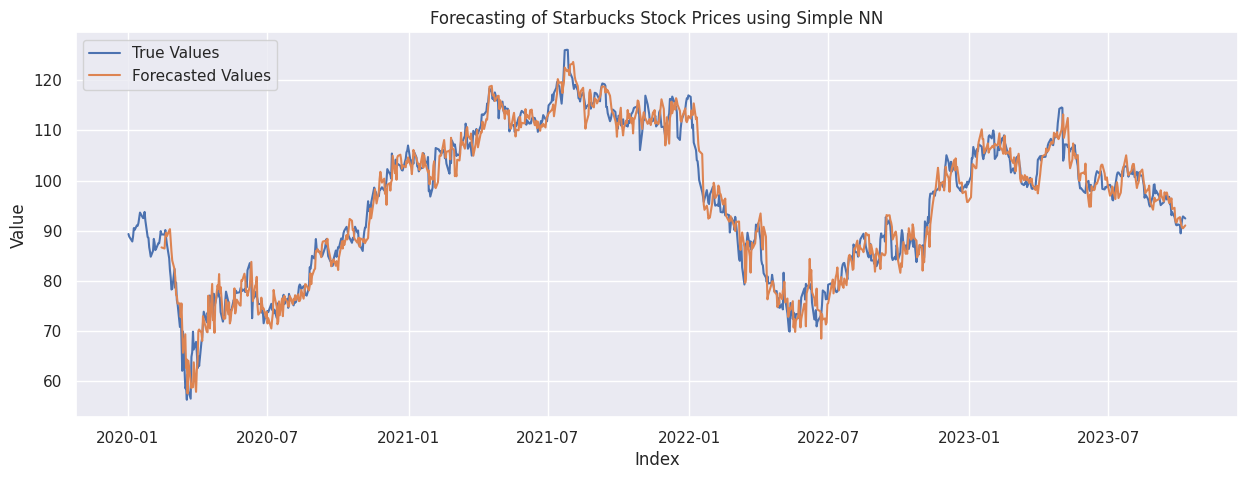

In [22]:
def plot_predictions(y_true, y_pred):
  sns.set()
  plt.figure(figsize=(15,5))
  plt.plot(y_true, label='True Values')
  plt.plot(y_pred, label='Forecasted Values')
  plt.title('Forecasting of Starbucks Stock Prices using Simple NN')
  plt.ylabel('Value')
  plt.xlabel('Index')
  plt.legend(loc ='upper left')
  plt.show()

plot_predictions(valid_close_data, forecast_series)

In [23]:
print(valid_close_data.head(5), '\n')
print(forecast_series.head(5))

Date
2020-01-02    89.349998
2020-01-03    88.830002
2020-01-06    88.129997
2020-01-07    87.860001
2020-01-08    88.879997
Name: Close, dtype: float64 

Date
2020-02-14    86.683189
2020-02-18    86.460289
2020-02-19    88.944336
2020-02-20    89.593597
2020-02-21    88.907867
Name: Forecast, dtype: float32


In [24]:
print('Valid Data:', len(valid_close_data))
print('Forecasted Data:', len(forecast_series))

Valid Data: 949
Forecasted Data: 919


In [25]:
valid_close_data = valid_close_data[window_size: ]
print('Valid Data:', len(valid_close_data))
print('Forecasted Data:', len(forecast_series))

Valid Data: 919
Forecasted Data: 919


In [26]:
print(valid_close_data.head(5), '\n')
print(forecast_series.head(5))

Date
2020-02-14    89.279999
2020-02-18    89.230003
2020-02-19    90.139999
2020-02-20    88.599998
2020-02-21    87.360001
Name: Close, dtype: float64 

Date
2020-02-14    86.683189
2020-02-18    86.460289
2020-02-19    88.944336
2020-02-20    89.593597
2020-02-21    88.907867
Name: Forecast, dtype: float32


In [28]:
import math
print(f'Mean Squared Error: {math.sqrt(mean_squared_error(valid_close_data, forecast_series).numpy())}')
print(f'Mean Squared Error: {mean_squared_error(valid_close_data, forecast_series).numpy()}')
print(f'Mean Absolute Error: {mean_absolute_error(valid_close_data, forecast_series).numpy()}')

Mean Squared Error: 2.851500795297714
Mean Squared Error: 8.131056785583496
Mean Absolute Error: 2.1868274211883545


### GRU

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [30]:
data = data.reset_index()


closed_data = data[['Date','Close']]
closed_data.shape

(7879, 2)

In [32]:
import plotly.express as px

fig = px.line(closed_data, x=closed_data.Date, y=closed_data.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [33]:
closedf = closed_data[closed_data['Date'] > '2020-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  949


In [34]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [35]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(949, 1)


In [36]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (569, 1)
test_data:  (380, 1)


In [37]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [38]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (538, 30)
y_train:  (538,)
X_test:  (349, 30)
y_test (349,)


In [39]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (538, 30, 1)
X_test:  (349, 30, 1)


In [40]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(64,return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.20))
model.add(GRU(64,return_sequences=True))
model.add(Dropout(0.20))
model.add(GRU(64))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            24960     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [41]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1,callbacks=[early_stopping, lr_schedule])


Epoch 1/200
17/17 [==============================] - 13s 210ms/step - loss: 0.4691 - mae: 0.6360 - val_loss: 0.3805 - val_mae: 0.5971 - lr: 1.0000e-06
Epoch 2/200
17/17 [==============================] - 2s 108ms/step - loss: 0.4683 - mae: 0.6347 - val_loss: 0.3779 - val_mae: 0.5950 - lr: 1.0798e-06
Epoch 3/200
17/17 [==============================] - 1s 82ms/step - loss: 0.4636 - mae: 0.6324 - val_loss: 0.3750 - val_mae: 0.5927 - lr: 1.1659e-06
Epoch 4/200
17/17 [==============================] - 1s 74ms/step - loss: 0.4566 - mae: 0.6269 - val_loss: 0.3719 - val_mae: 0.5902 - lr: 1.2589e-06
Epoch 5/200
17/17 [==============================] - 1s 66ms/step - loss: 0.4552 - mae: 0.6259 - val_loss: 0.3687 - val_mae: 0.5875 - lr: 1.3594e-06
Epoch 6/200
17/17 [==============================] - 1s 79ms/step - loss: 0.4517 - mae: 0.6231 - val_loss: 0.3651 - val_mae: 0.5847 - lr: 1.4678e-06
Epoch 7/200
17/17 [==============================] - 2s 107ms/step - loss: 0.4512 - mae: 0.6223 - val_l

128


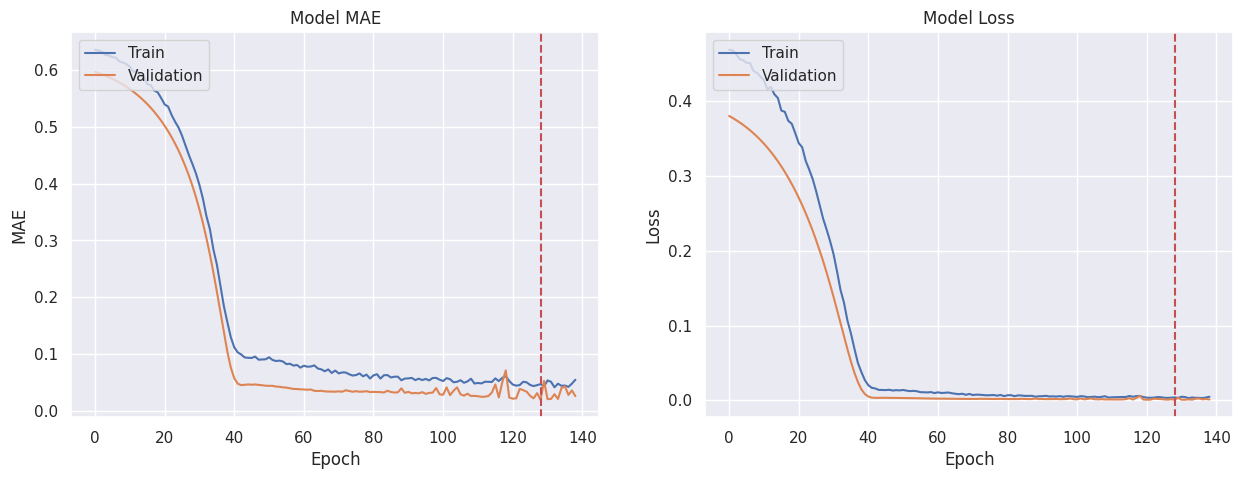

In [42]:

def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='r', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='r', linestyle='--')

  plt.show()


plot_history(history)

At epoch 121

In [43]:
### Predictions and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

11/11 [==============================] - 0s 13ms/step


((538, 1), (349, 1))

In [44]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.0815226926841874
Train data MSE:  4.332736720159231
Train data MAE:  1.5116564456414998
-------------------------------------------------------------------------------------
Test data RMSE:  1.7865688953997956
Test data MSE:  3.1918284180100454
Test data MAE:  1.3396856094841287


In [46]:
# shift train predictions for plotting
from itertools import cycle

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparison between original close price vs predicted close price using GRU model',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (949, 1)
Test predicted data:  (949, 1)


### Anomaly Detection

In [47]:
!pip install adtk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00


In [48]:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import *

<Axes: >

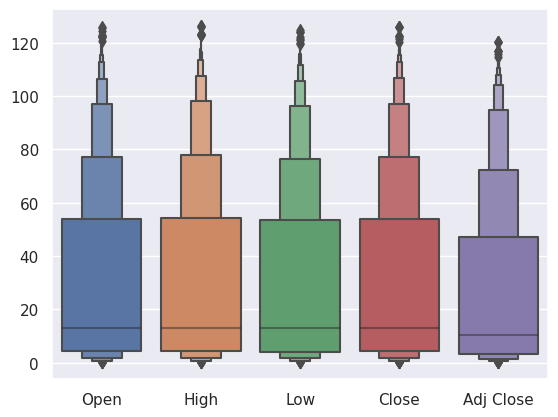

In [49]:
del data['Volume']
sns.boxenplot(data)

In [50]:
open_data = data[['Date','Open']]
open_data.describe()

,Open
count,7879.000000
mean,28.814568
std,32.753002
min,0.328125
25%,4.311250
50%,13.035000
75%,54.035000
max,126.080002


In [51]:
open_data = open_data.set_index('Date')

###### Threshold Detector


Detector that detects anomaly based on user-given threshold
This detector compares time series with user-given thresholds, and identifies time points as anomalies when values are beyond the thresholds


Text(0.5, 1.0, 'Threshold Anomaly Detection')

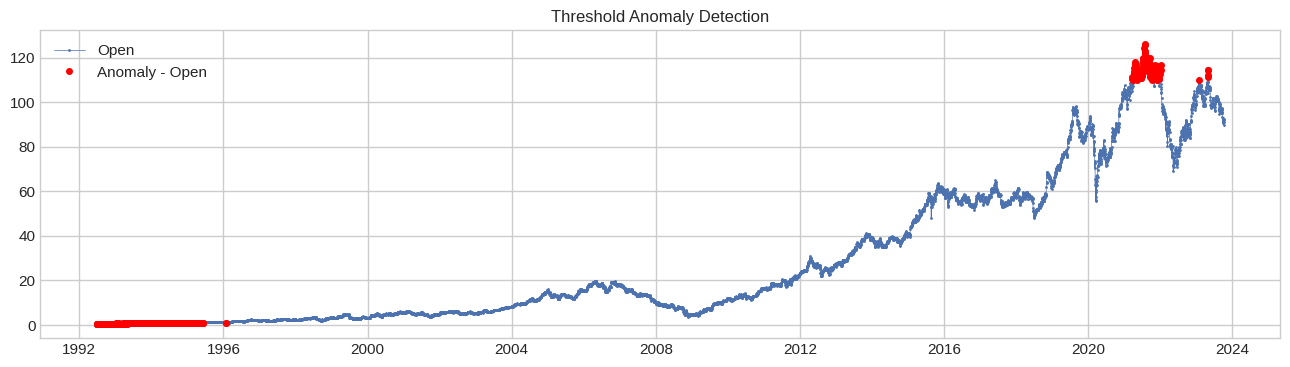

In [52]:
threshold_detector = ThresholdAD(low=1, high=110)
anomalies = threshold_detector.detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Threshold Anomaly Detection')

###### Quantile Detector


Detects anomaly based on quantiles of historical data
Detector compares time series values with user specified quantiles of historical data, and identifies time points anomalous when values are beyond thresholds

###### Interquartile Detector

Detects anomaly based on inter-quartile range of historical data
Detector compares time series values with 1st and 3rd quartiles of historical data, identifies time points as anomalous when differences are beyond the inter-quartile range (IQR) times a user given factor c

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

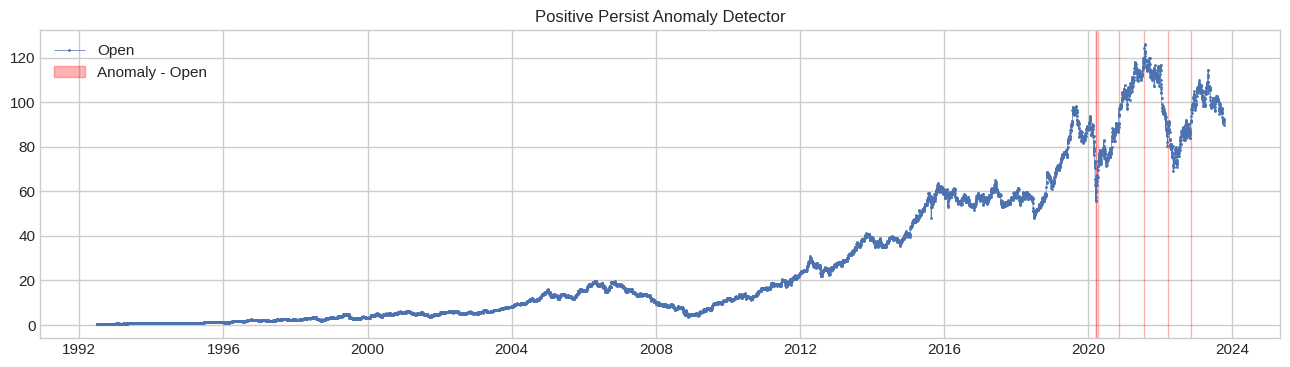

In [53]:
persist_detector = PersistAD(c=15, side='positive')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Positive Persist Anomaly Detector')

Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

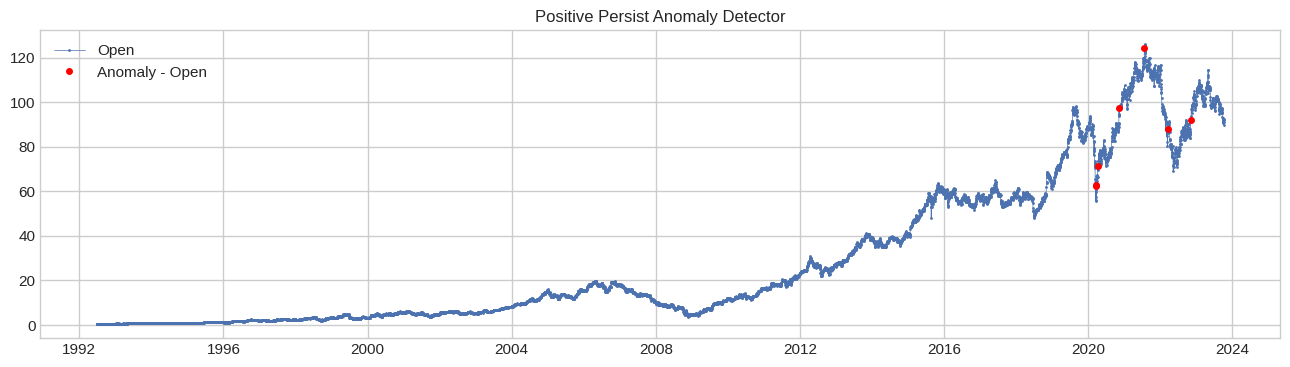

In [54]:
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Positive Persist Anomaly Detector')

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

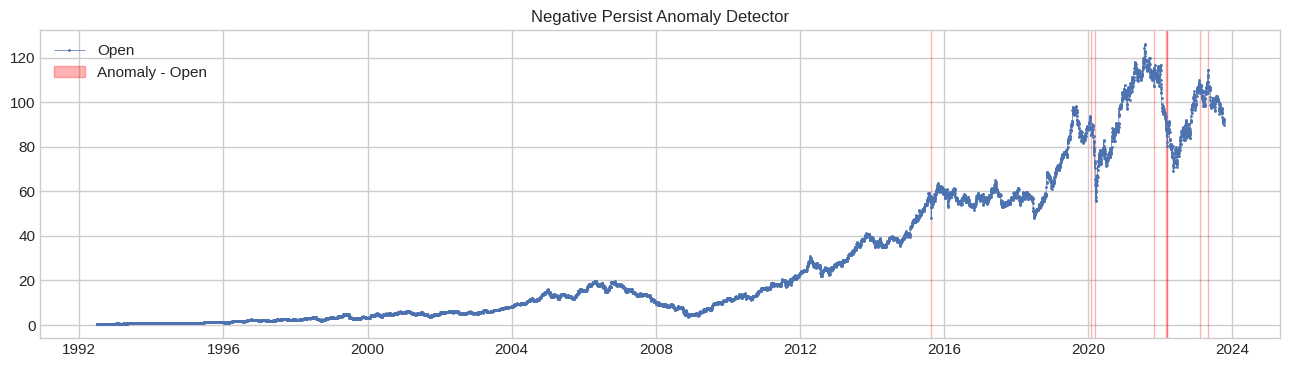

In [55]:
persist_detector = PersistAD(c=15, side='negative')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Negative Persist Anomaly Detector')

Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

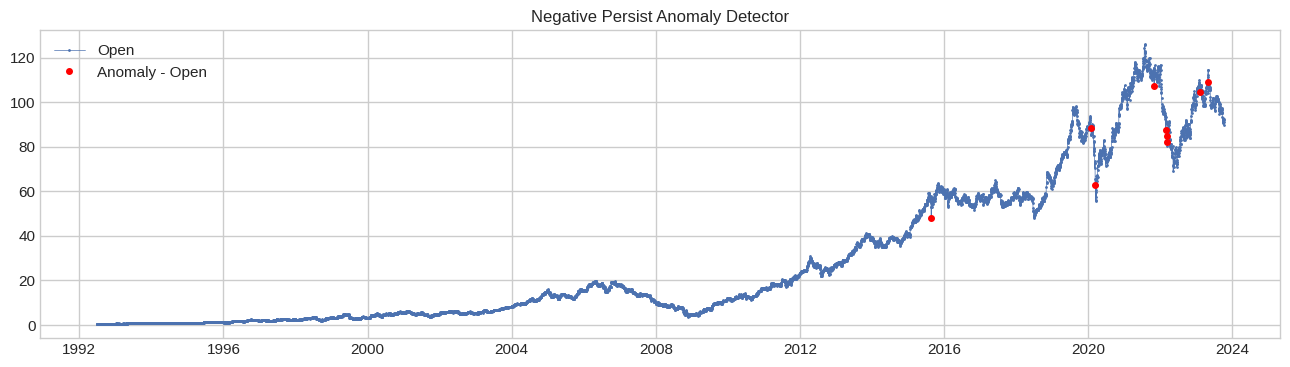

In [56]:
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Negative Persist Anomaly Detector')

###### Volatility Detector

Detects shift of volatility in TS
Detector compares volatility of two time windows next to each other, identifies the time point in between as a volatility shift point if the difference of the volatility measurement in the two time windows is anomalously large

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Text(0.5, 1.0, 'Volatility Anomaly Detection')

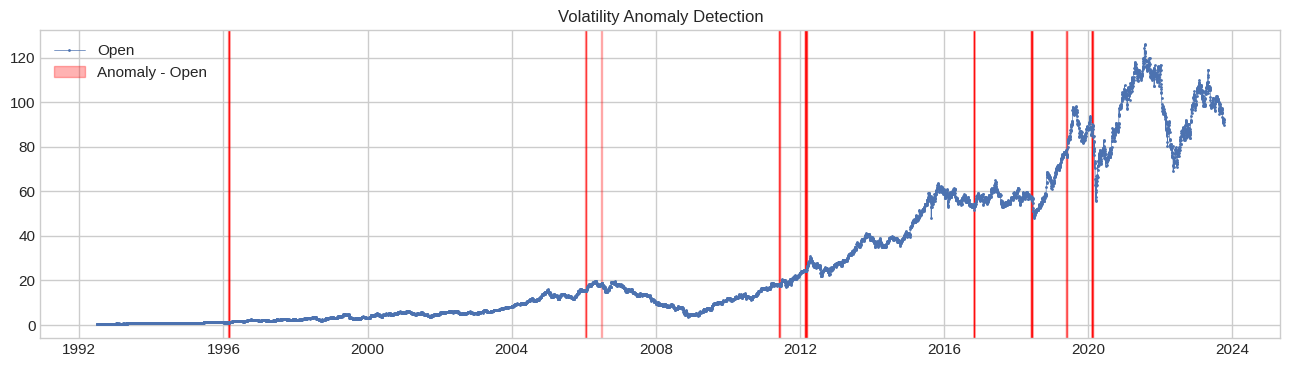

In [57]:
volatility_detector = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Volatility Anomaly Detection')